In [327]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import TimeSeriesSplit # you have everything done for you
from sklearn.model_selection import cross_val_score

%matplotlib inline

In [328]:
#data = pd.read_csv('ads.csv', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('ik03_z.csv', index_col=['Time'], parse_dates=['Time'])
#data1 = pd.read_csv('iat1.csv', index_col=['Time'], parse_dates=['Time'])
dtest = pd.read_csv('iat3.txt', index_col=['Time'], parse_dates=['Time'])
data = pd.read_csv('iat3_clear.txt', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('iat3x.txt', index_col=['Time'], parse_dates=['Time'])
#data = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])
data.columns = ["y"]
#ads = pd.read_csv('currency.csv', index_col=['Time'], parse_dates=['Time'])

In [329]:
print(len(dtest))

3983


,y
count,3978.000000
mean,1785.572875
std,0.005592
min,1785.549600
25%,1785.569180
50%,1785.572890
75%,1785.576828
max,1785.591120


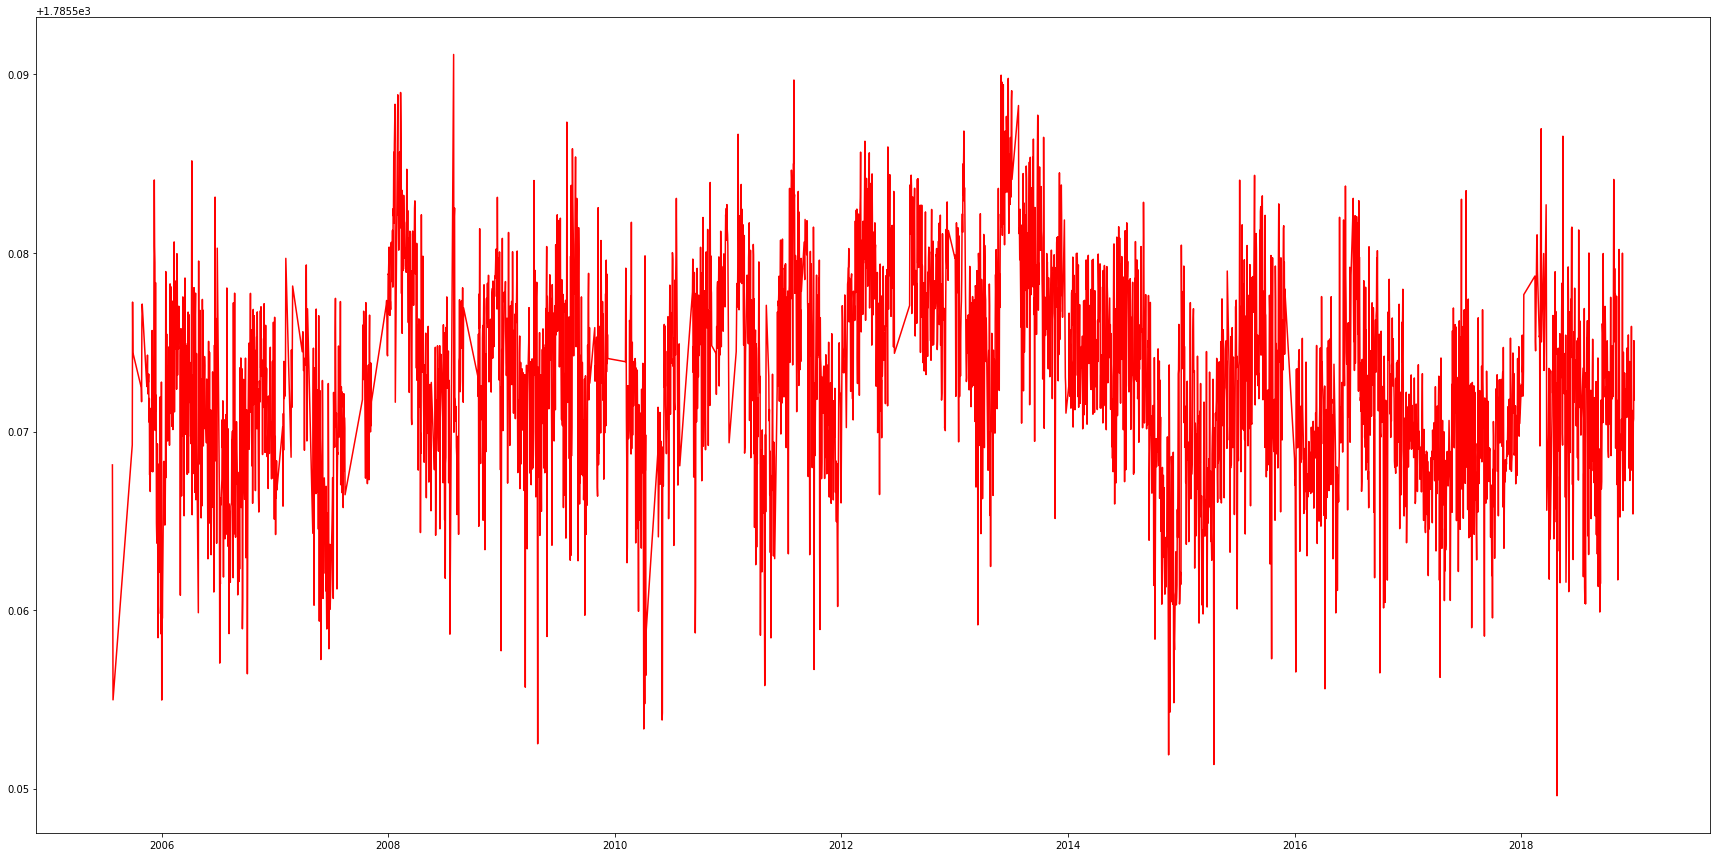

In [330]:
#print(data.head(3))
#print(data.describe())

plt.figure(figsize=(30, 15))
plt.plot(data, "r", label="prediction")
#plt.plot(data.values, label="actual")
data.describe()


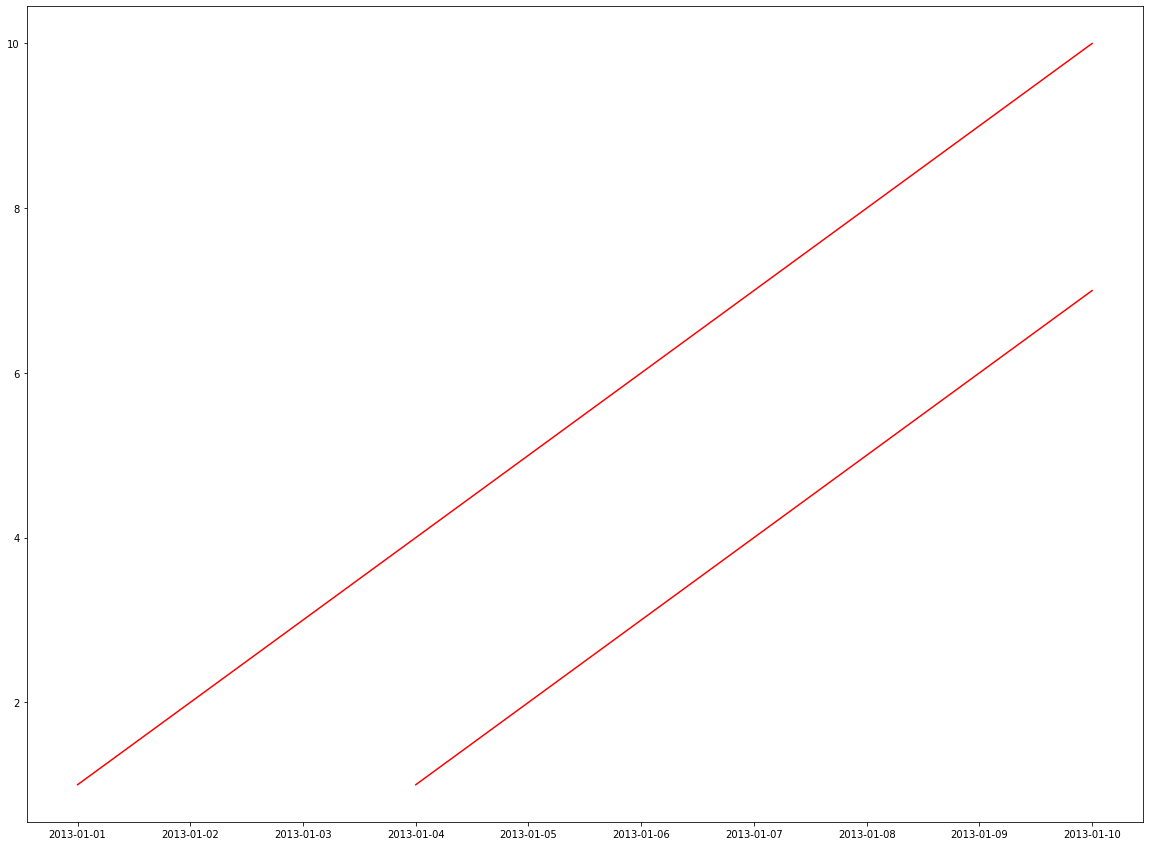

In [331]:
#dff = pd.DataFrame({'Col1': [10, 20, 15, 30, 45],
#                    'Time': ['2005-07-26', '2005-07-27','2005-07-28','2005-09-28','2005-09-29']})
#dff.columns = ["y"]
#dff["lag_{}".format(1)] = data.shift(1)
dates = pd.date_range('20130101', periods=10)

dff = pd.DataFrame({'y':[1,2,3,4,5,6,7,8,9,10]},index=dates)
dff["lag_{}".format(3)] = dff.shift(3)
#dff["lag_{}".format(4)] = dff.shift(4)
#dff["lag_{}".format(5)] = dff.shift(5)
plt.figure(figsize=(20, 15))
plt.plot(dff, "r", label="prediction")


In [332]:
def code_mean(data, cat_feature, real_feature):
    """
    Returns a dictionary where keys are unique categories of the cat_feature,
    and values are means over real_feature
    """
    return dict(data.groupby(cat_feature)[real_feature].mean())

In [333]:
def prepareData(data, lag_start=5, lag_end=20, test_size=0.15):
# Добавляет лаги сдвигает вниз от и до 
    data = pd.DataFrame(data.copy())
    data.columns = ["y"]

    # считаем индекс в датафрейме, после которого начинается тестовыый отрезок
    test_index = int(len(data)*(1-test_size))
    print(test_index)

    # добавляем лаги исходного ряда в качестве признаков
    for i in range(lag_start, lag_end):
        data["lag_{}".format(i)] = data.y.shift(i)
        #print(data)
    data.index = pd.to_datetime(data.index)
    #data.index = data.index.to_datetime()
#    data["hour"] = data.index.hour
#    data["weekday"] = data.index.weekday
#    data['is_weekend'] = data.weekday.isin([5,6])*1

    # считаем средние только по тренировочной части, чтобы избежать лика
    #                               сред                          
#    data['weekday_average'] = list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday))
    #print(list(map(code_mean(data[:test_index], 'weekday', "y").get, data.weekday)))
#    data["hour_average"] = list(map(code_mean(data[:test_index], 'hour', "y").get, data.hour))

    # выкидываем закодированные средними признаки 
#    data.drop(["hour", "weekday","is_weekend"], axis=1, inplace=True)

    data = data.dropna()
    data = data.reset_index(drop=True)

    # разбиваем весь датасет на тренировочную и тестовую выборку
    X_train = data.loc[:test_index].drop(["y"], axis=1)
    y_train = data.loc[:test_index]["y"]
    X_test = data.loc[test_index:].drop(["y"], axis=1)
    y_test = data.loc[test_index:]["y"]

    return X_train, X_test, y_train, y_test

In [334]:
#print(data.describe())
X_train, X_test, y_train, y_test = prepareData(data, test_size=0.2, lag_start=2, lag_end=4)
#X_train1, X_test1, y_train1, y_test1 = prepareData(data1, test_size=0.1, lag_start=1, lag_end=2)
#X_train.describe()
#print(y_test)


3182


In [335]:
tscv = TimeSeriesSplit(n_splits=3)


3186


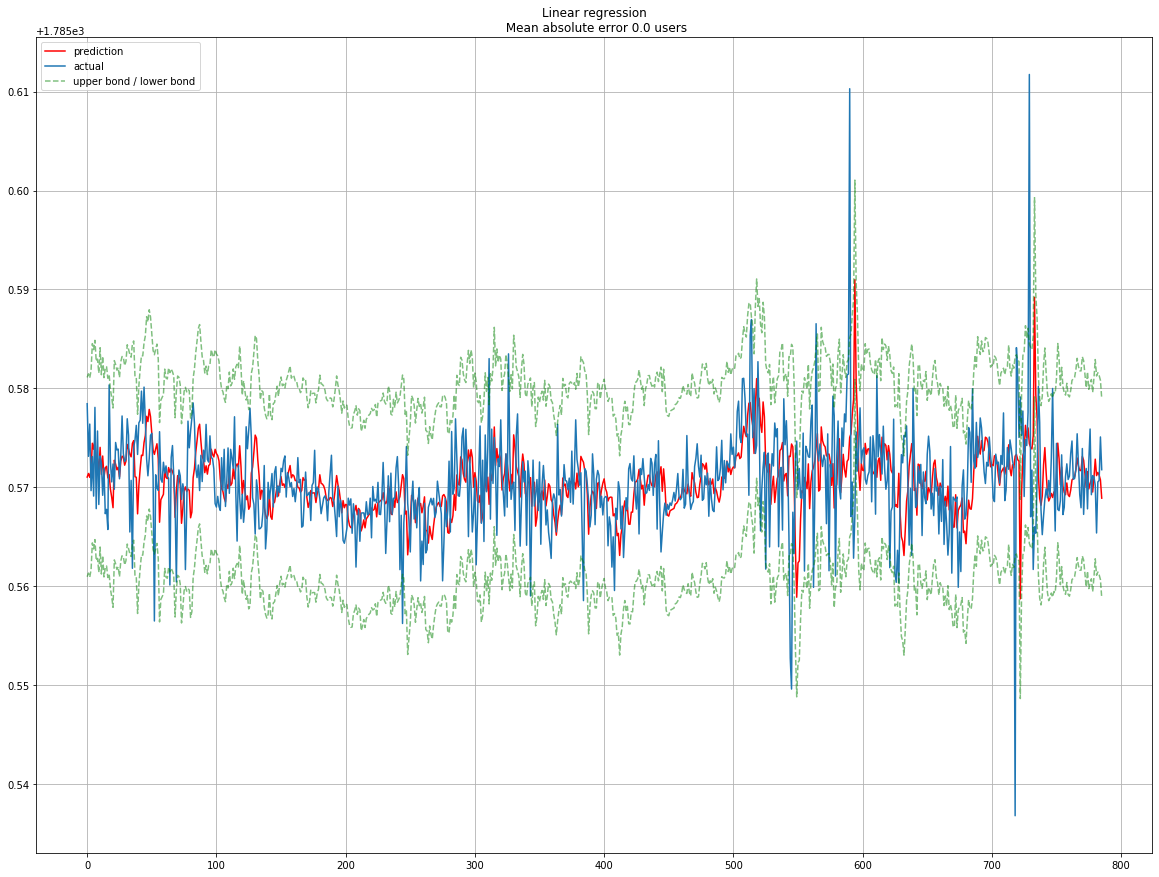

In [341]:
from sklearn.linear_model import LinearRegression

X_train, X_test, y_train, y_test = prepareData(dtest, test_size=0.2, lag_start=4, lag_end=12)

lr = LinearRegression()
lr.fit(X_train, y_train)
#new_df = pd.concat([X_train, X_test])
#print(new_df)
prediction = lr.predict(X_test)
cv = cross_val_score(lr, X_train, y_train, 
                                    cv=tscv, 
                                    scoring="neg_mean_absolute_error")
mae = cv.mean() * (-1)
deviation = cv.std()

scale = 1.96
lower = prediction - (mae + scale * deviation)
upper = prediction + (mae + scale * deviation)

plt.figure(figsize=(20, 15))
plt.plot(prediction, "r", label="prediction")
plt.plot(y_test.values, label="actual")
plt.plot(lower, "g--", label="upper bond / lower bond", alpha=0.5)
plt.plot(upper, "g--", alpha=0.5)
plt.legend(loc="best")
plt.title("Linear regression\n Mean absolute error {} users".format(round(mean_absolute_error(prediction, y_test))))
plt.grid(True);

2788


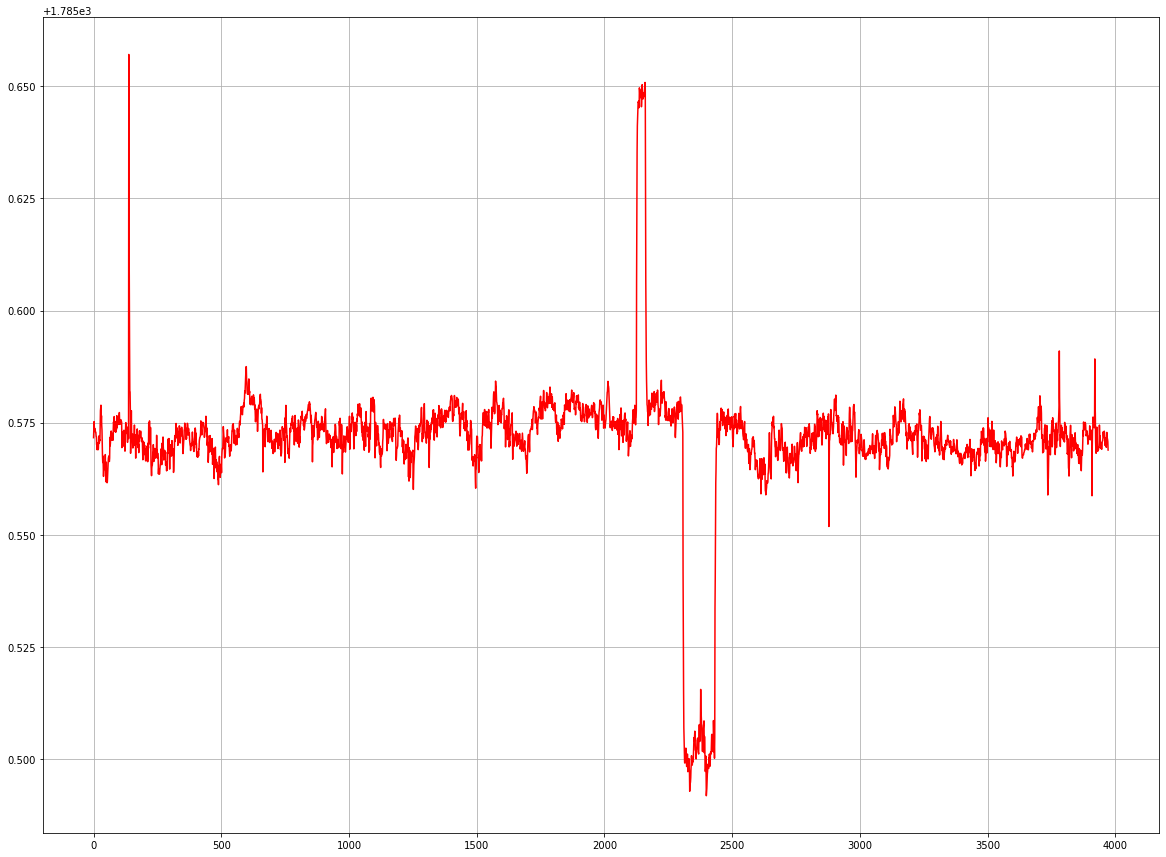

In [342]:
X_dtrain, X_dtest, y_dtrain, y_dtest = prepareData(dtest, test_size=0.3, lag_start=4, lag_end=12)


new_df = pd.concat([X_dtrain, X_dtest])
y_df = pd.concat([y_dtrain, y_dtest])
#print(len(new_df))
prediction = lr.predict(new_df)
prediction
#cv = cross_val_score(lr, X_train, y_train, 
#                                    cv=tscv, 
#                                    scoring="neg_mean_absolute_error")
#mae = cv.mean() * (-1)
#deviation = cv.std()

#scale = 1.96
#lower = prediction - (mae + scale * deviation)
#upper = prediction + (mae + scale * deviation)
#print(new_df)
#plt.figure(figsize=(20, 15))
#plt.plot(new_df, "g", label="iat3")
plt.figure(figsize=(20, 15))
plt.plot(prediction, "r", label="prediction")
#plt.plot(y_df.values, label="actual")
plt.grid(True);


## Cross Validation

In [343]:

def performTimeSeriesCV(X_train, y_train, number_folds, model, metrics):
   # print(X_train)
    print('Размер обучаюший выборки: {}'.format(X_train.shape))
    # возвращает целую часть дел на кол фолдов разбиения
    k = int(np.floor(float(X_train.shape[0]) / number_folds))
    print('Размер каждой складки: {}'.format(k))

    errors = np.zeros(number_folds-1) #   [0.0.0.0] 

    # Цикл второго фолда до последнего    
    for i in range(2, number_folds + 1):
        print('')
        split = float(i-1)/i
        print('Разбиение первой  ' + str(i) + ' куски в ' + str(i-1) + '/' + str(i) )

        X = X_train[:(k*i)]
        y = y_train[:(k*i)]
        print('Размер обучающей + тестовой: {}'.format(X.shape)) # the size of the dataframe is going to be k*i

        index = int(np.floor(X.shape[0] * split))

        # folds used to train the model        
        X_trainFolds = X[:index]        
        y_trainFolds = y[:index]

        # fold used to test the model
        X_testFold = X[(index + 1):]
        y_testFold = y[(index + 1):]

        model.fit(X_trainFolds, y_trainFolds)
        errors[i-2] = metrics(model.predict(X_testFold), y_testFold)

    # the function returns the mean of the errors on the n-1 folds    
    return errors.mean()

In [344]:
%%time
performTimeSeriesCV(X_train, y_train, 2, lr, mean_absolute_error)

Размер обучаюший выборки: (3187, 8)
Размер каждой складки: 1593

Разбиение первой  2 куски в 1/2
Размер обучающей + тестовой: (3186, 8)
Wall time: 30 ms


0.007109200147420698

# XGBoost Python

In [345]:
data.head()

,y
Time,
2005-07-26,1785.56813
2005-07-27,1785.56149
2005-07-28,1785.55497
2005-09-28,1785.56925
2005-09-29,1785.57725


In [355]:
import xgboost as xgb

def XGB_forecast(data, lag_start=5, lag_end=20, test_size=0.15, scale=1.96):

    # исходные данные
    X_train, X_test, y_train, y_test = prepareData(data, lag_start, lag_end, test_size)
    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test)

    # задаём параметры
    params = {
        'objective': 'reg:linear',
        'booster':'gblinear'
    }
    trees = 1000

    # прогоняем на кросс-валидации с метрикой rmse
    cv = xgb.cv(params, dtrain, metrics = ('rmse'), verbose_eval=False, nfold=10, show_stdv=False, num_boost_round=trees)
    
    print('chislo  ',cv['test-rmse-mean'].argmin())
    # обучаем xgboost с оптимальным числом деревьев, подобранным на кросс-валидации
    bst = xgb.train(params, dtrain, num_boost_round=cv['test-rmse-mean'].argmin())

    # можно построить кривые валидации
    #cv.plot(y=['test-mae-mean', 'train-mae-mean'])
    #cv.plot(y=['test-rmse-mean', 'train-rmse-mean'])

    # запоминаем ошибку на кросс-валидации
    deviation = cv.loc[cv['test-rmse-mean'].argmin()]["test-rmse-mean"]

    # посмотрим, как модель вела себя на тренировочном отрезке ряда
    #plt.plot.label(' модель вела себя на тренировочном отрезке ряда')
    prediction_train = bst.predict(dtrain)
    plt.figure(figsize=(15, 5))
    plt.plot(prediction_train)
    plt.plot(y_train)
    plt.axis('tight')
    plt.grid(True)

    # и на тестовом
    prediction_test = bst.predict(dtest)
    lower = prediction_test-scale*deviation
    upper = prediction_test+scale*deviation

    Anomalies = np.array([np.NaN]*len(y_test))
    Anomalies[y_test<lower] = y_test[y_test<lower]

    plt.figure(figsize=(15, 5))
    plt.plot(prediction_test, label="prediction")
    plt.plot(lower, "r--", label="upper bond / lower bond")
    plt.plot(upper, "r--")
    plt.plot(list(y_test), label="y_test")
    plt.plot(Anomalies, "ro", markersize=10)
    plt.legend(loc="best")
    plt.axis('tight')
    plt.title("XGBoost Mean absolute error {} users".format(round(mean_absolute_error(prediction_test, y_test))))
    plt.grid(True)
    plt.legend()
    print(bst)

,y
Time,
2005-07-26,1785.56813
2005-07-27,1785.56149
2005-07-28,1785.55497
2005-09-28,1785.56925
2005-09-29,1785.57725
2005-09-30,1785.57442
2005-10-27,1785.57246
2005-10-28,1785.57167
2005-10-29,1785.57607


3182
[08:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:38] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:00:38] 

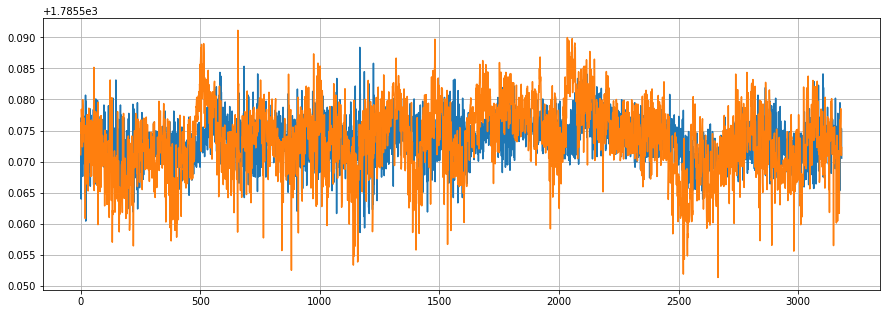

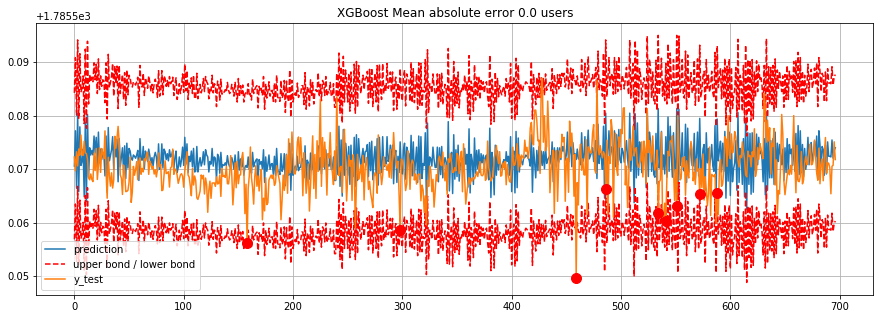

In [360]:
XGB_forecast(data, test_size=0.2, lag_start=24, lag_end=100)

2788
[07:59:50] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


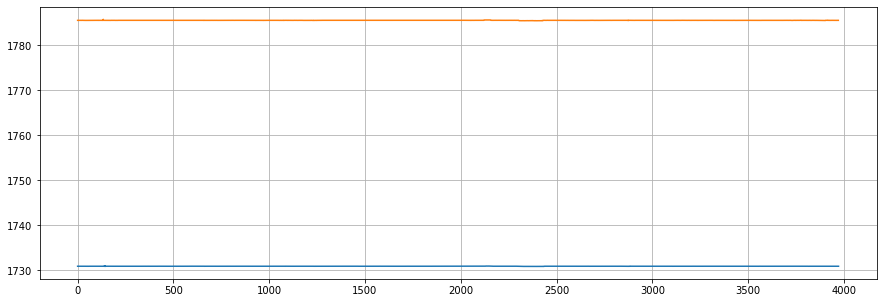

In [357]:
# задаём параметры
params = {
    'objective': 'reg:linear',
    'booster':'gblinear'
}
trees = 1000

# исходные данные
X_train, X_test, y_train, y_test = prepareData(dtest, 2, 2, 0.3)
new_X = pd.concat([X_dtrain, X_dtest])
new_y = pd.concat([y_dtrain, y_dtest])
dtrain = xgb.DMatrix(new_X, label=new_y)

bst = xgb.train(params, dtrain, 1)
#dtest = xgb.DMatrix(X_test)
# посмотрим, как модель вела себя на тренировочном отрезке ряда
predict_train = bst.predict(dtrain)
plt.figure(figsize=(15, 5))
plt.plot(predict_train)
plt.plot(new_y)
#plt.axis('tight')
plt.grid(True)

In [358]:
#X = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
X = np.array([[5, 2], [6, 4], [5, 6], [7, 8], [9, 10], [11, 12], [13, 14]])
y = np.array([1, 2, 3, 4, 5, 6, 7, 8])
#tscv = TimeSeriesSplit(n_splits=2)

tscv =TimeSeriesSplit(max_train_size=None, n_splits=5)
print(tscv)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_train)
print(X_test)

TimeSeriesSplit(max_train_size=None, n_splits=5)
TRAIN: [0 1] TEST: [2]
TRAIN: [0 1 2] TEST: [3]
TRAIN: [0 1 2 3] TEST: [4]
TRAIN: [0 1 2 3 4] TEST: [5]
TRAIN: [0 1 2 3 4 5] TEST: [6]
[[ 5  2]
 [ 6  4]
 [ 5  6]
 [ 7  8]
 [ 9 10]
 [11 12]]
[[13 14]]
